# Pytorch CNN | Brain Tumor MRI Detection








In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import gc

In [ ]:
device_d = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device_d


device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Preparing the dataset**

In [ ]:
import os
dataset_path = '/content/drive/My Drive/DL_Final_Project/brain_tumor_dataset'

image_paths = []
image_labels = []

for label in ['yes','no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path,label)):
        for filename in filenames:
            image_paths.append(os.path.join(dirname, filename))
            image_labels.append(1 if label == 'yes' else 0)

len(image_paths), len(image_labels)

(253, 253)

In [ ]:
# image size details

sizes_i = []
for path in image_paths:
    im = Image.open(path)
    sizes_i.append(im.size)
    im.close()

print(max(sizes_i), min(sizes_i))

(1920, 1080) (150, 198)


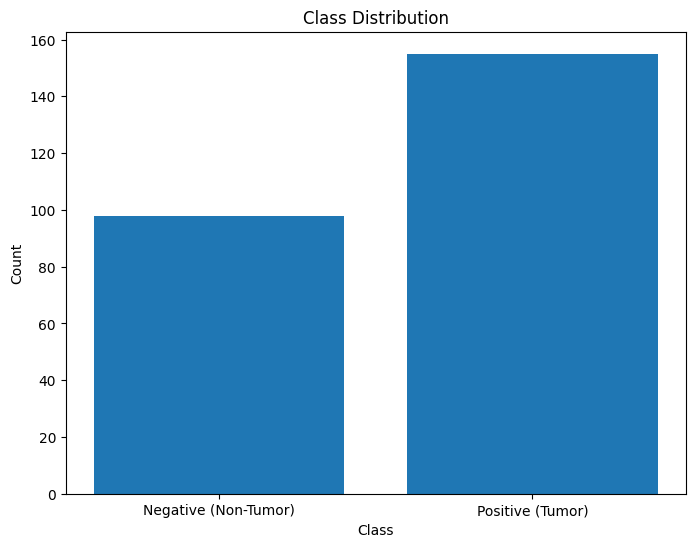

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the paths to positive and negative image folders
positive_folder = "/content/drive/My Drive/DL_Final_Project/brain_tumor_dataset/yes"
negative_folder = "/content/drive/My Drive/DL_Final_Project/brain_tumor_dataset/no"

# Count the number of images in each class
num_positive_images = len([f for f in os.listdir(positive_folder) if os.path.isfile(os.path.join(positive_folder, f))])
num_negative_images = len([f for f in os.listdir(negative_folder) if os.path.isfile(os.path.join(negative_folder, f))])

# Create a bar chart to visualize the class distribution
plt.figure(figsize=(8, 6))
plt.bar(['Negative (Non-Tumor)', 'Positive (Tumor)'], [num_negative_images, num_positive_images])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


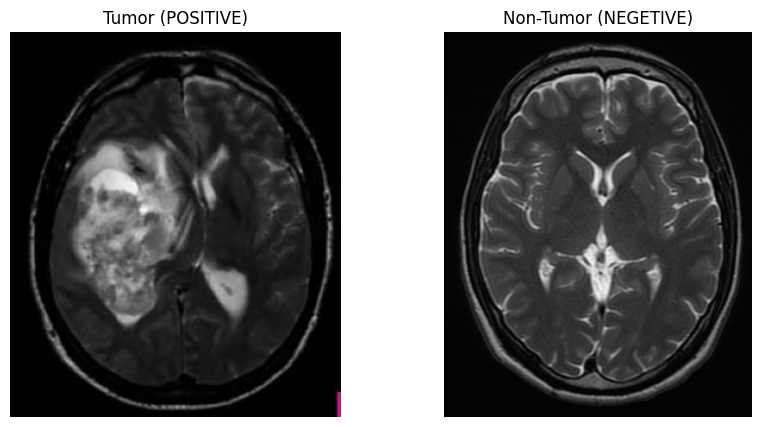

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Paths to sample MRI scans
sample_positive_img = '/content/drive/My Drive/DL_Final_Project/brain_tumor_dataset/yes/Y259.JPG'
sample_negative_img = '/content/drive/My Drive/DL_Final_Project/brain_tumor_dataset/no/No22.jpg'

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, sample_path in enumerate([sample_positive_img, sample_negative_img]):
    img = Image.open(sample_path)
    axes[i].imshow(img)
    axes[i].set_title('Tumor (POSITIVE)' if i == 0 else 'Non-Tumor (NEGETIVE)')
    axes[i].axis('off')

plt.show()

In [ ]:
# stratified split into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_paths,
                                                    image_labels,
                                                    stratify=image_labels,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1357
                                                   )

print(len(X_train), len(X_test))

202 51


## Custom Dataset

In [ ]:
from torch.utils.data import Dataset

class MRIDataset(Dataset):
    def __init__(self, paths, labels, oversample_minority=False, augmentations=None):
        self.paths = image_paths
        self.labels = image_labels
        self.oversample_minority = oversample_minority

        if augmentations is None:
            self.augmentations = transforms.Compose([transforms.ToTensor()])
        else:
            self.augmentations = augmentations

        if oversample_minority:
            self.oversample()

    def oversample(self):
        # Identify minority class
        minority_class = 1 if sum(self.labels) < len(self.labels) / 2 else 0
        minority_indices = [i for i, label in enumerate(self.labels) if label == minority_class]

        # Oversample the minority class
        self.paths.extend([self.paths[i] for i in minority_indices])
        self.labels.extend([self.labels[i] for i in minority_indices])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        label = self.labels[index]

        sample = Image.open(self.paths[index]).convert(mode="RGB")
        sample = self.augmentations(sample)

        return (sample, torch.tensor(label, dtype=torch.float))


## Augmentations

In this particular dataset, all the MRIs are straight, mostly grayscale, *different sizes*, mostly centered.

I've decided on the following:

- Resize to 224x224px
- RandomHorizontalFlip(0.2)
- RandomVerticalFlip(0.1)
- RandomAutoContrast(0.2)
- RandomAutoSharpness(0.3)

Both for training and testing datasets.

In [ ]:
train_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

test_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

In [ ]:
train_dataset = MRIDataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_augmentations)

**NOTE**

- Pillow Images on transforms are in the shape (channels, height, width). To plot them, we need to reshape them to (height, width, channels). Hence usage of torch.permute(), 1: height, 2: width, 3: channels

torch.Size([3, 224, 224])
1.0


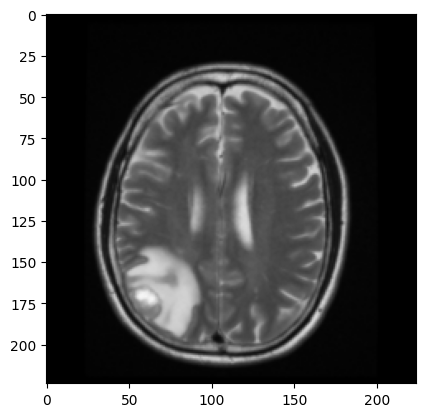

In [ ]:
import matplotlib.pyplot as plt

# Get a random sample and its label from the test dataset
random_sample, random_label = test_dataset[0]

# Print the shape of the sample (image)
print(random_sample.shape)

# Display the image, permuting the dimensions to match (C, H, W) -> (H, W, C) for visualization
plt.imshow(random_sample.permute(1, 2, 0))

# Print the label (tumor or no tumor)
print(random_label.item())


# **Model**

## Model Config

In [ ]:
class Config:
    learning_rate = 0.0005
    epochs = 50
    train_batch_size = 16
    test_batch_size = 8

## DataLoaders

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = Config.train_batch_size,
                                               shuffle = True,
                                               num_workers = 2
                                              )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = Config.test_batch_size,
                                              shuffle = True,
                                              num_workers = 2
                                              )

len(train_dataloader), len(test_dataloader)

(16, 32)

# **CNN Model**

**Conv2d**

input:
```
width1 * height1 * in_channels
kernel_size: f
num_filters: k
stride: s
padding: p
```

output:
```
width2 = (width1 - f + 2*p)/s + 1
height2 = (height1 - f + 2*p)/s + 1
out_channels = k
```
    
**MaxPool2d**

input:
```
width1 * height1 * in_channels
kernel_size: f
stride: s
```
output:
```
width2 = (width1 - f)/s + 1
height2 = (height1 - f)/s + 1
out_channels = in_channels
```


In [ ]:
import torch.nn as nn
import torch
from torchvision import models

class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        # Load pre-trained ResNet-50
        resnet50 = models.resnet50(pretrained=True)
        # Extract the convolutional layers from ResNet-50
        self.conv_block = nn.Sequential(*list(resnet50.children())[:-2])
        # Add a global average pooling layer
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        # Add a dropout layer
        self.dropout = nn.Dropout(0.5)
        # Add a fully connected layer for binary classification
        self.fc = nn.Linear(2048, 1)

    def forward(self, x):
        x = self.conv_block(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Create an instance of the ResNetModel
model = ResNetModel()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


In [ ]:

print(model)

ResNetModel(
  (conv_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [ ]:
device_d = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device_d)

# **Training**

In [ ]:
import matplotlib.pyplot as plt
class Trainer:

    def __init__(self, model, dataloaders, Config):
        self.model = model
        self.train, self.test = dataloaders

        self.Config = Config

        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate,betas = (0.9,0.999) )

        self.loss_fn = nn.BCEWithLogitsLoss()


    def binary_accuracy(self, outputs, labels):
        return (torch.round(torch.sigmoid(outputs)) == labels).sum().item() / labels.shape[0]


    def train_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for X,y in self.train:

            X = X.to(device_d, dtype = torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device_d, dtype = torch.float)

            self.optim.zero_grad()

            outputs = self.model(X)
            loss = self.loss_fn(outputs, y)

            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.binary_accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        train_loss = running_loss / len(self.train)
        train_acc = running_acc / len(self.train)

        return train_loss, train_acc


    def fit(self):

        losses = []
        accuracies = []

        for epoch in range(self.Config.epochs):

            self.model.train()

            train_loss, train_acc = self.train_one_epoch()
            losses.append(train_loss)
            accuracies.append(train_acc)

            print(f"EPOCH {epoch+1}/{self.Config.epochs}")
            print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}\n\n")

         # Plotting training loss
        plt.plot(range(1, self.Config.epochs + 1), losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.show()

        # Plotting training accuracy
        plt.plot(range(1, self.Config.epochs + 1), accuracies, label='Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy Over Epochs')
        plt.legend()
        plt.show()


    @torch.no_grad()
    def inference(self):

        self.model.eval()

        running_acc = 0

        for X,y in self.test:

            X = X.to(device_d, torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device_d, dtype = torch.float)
            outputs = self.model(X)
            running_acc += self.binary_accuracy(outputs, y)

            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()

        accuracy = running_acc / len(self.test)

        return accuracy




EPOCH 1/50
Training Loss: 0.5371373575180769 | Training Accuracy: 0.7394831730769231


EPOCH 2/50
Training Loss: 0.30672189639881253 | Training Accuracy: 0.9017427884615384


EPOCH 3/50
Training Loss: 0.23730610078200698 | Training Accuracy: 0.88671875


EPOCH 4/50
Training Loss: 0.14380257669836283 | Training Accuracy: 0.9444110576923077


EPOCH 5/50
Training Loss: 0.2824677089229226 | Training Accuracy: 0.9092548076923077


EPOCH 6/50
Training Loss: 0.148096043150872 | Training Accuracy: 0.9453125


EPOCH 7/50
Training Loss: 0.07663664664141834 | Training Accuracy: 0.98046875


EPOCH 8/50
Training Loss: 0.07663568574935198 | Training Accuracy: 0.97265625


EPOCH 9/50
Training Loss: 0.027154128765687346 | Training Accuracy: 1.0


EPOCH 10/50
Training Loss: 0.04890029667876661 | Training Accuracy: 0.98828125


EPOCH 11/50
Training Loss: 0.050198490265756845 | Training Accuracy: 0.984375


EPOCH 12/50
Training Loss: 0.0619531175470911 | Training Accuracy: 0.9765625


EPOCH 13/50
Trainin

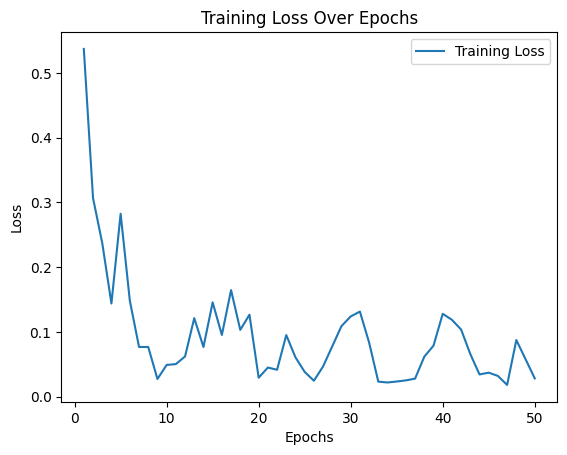

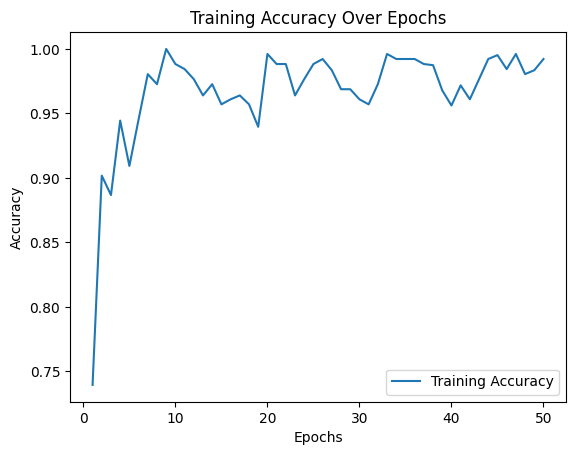

In [ ]:
trainer = Trainer(model, (train_dataloader, test_dataloader), Config)
trainer.fit()

In [ ]:
accuracy = trainer.inference()
accuracy*100

100.0

In [ ]:
model_path = "/content/drive/My Drive/DL_Final_Project/Brain_tumor_RESNET_model"

In [ ]:
torch.save(model.state_dict(), model_path)

## Loading  the model

In [ ]:
Loaded_model = model.load_state_dict(torch.load(model_path))

<ipython-input-27-76d0a1a74e49>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Loaded_model = model.load_state_dict(torch.load(model_path))


In [ ]:
print(Loaded_model)

<All keys matched successfully>


## Testing the sample image

In [ ]:
sample_1 = '/content/drive/My Drive/DL_Final_Project/brain_tumor_dataset/yes/Y259.JPG'
sample_2 = '/content/drive/My Drive/DL_Final_Project/brain_tumor_dataset/no/No22.jpg'

<ipython-input-32-9e450f4960c7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


Raw scores: tensor([[-1.7664]])
Predicted probabilities: tensor([[0.1460]])
Predicted class: 0.0
The model predicts: No


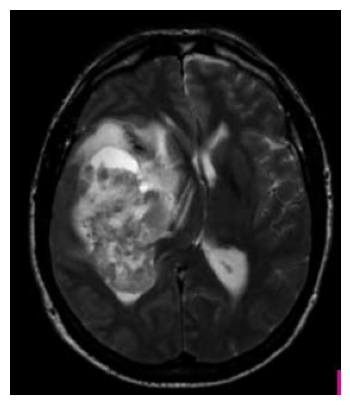

Raw scores: tensor([[-1.7784]])
Predicted probabilities: tensor([[0.1445]])
Predicted class: 0.0
The model predicts: No


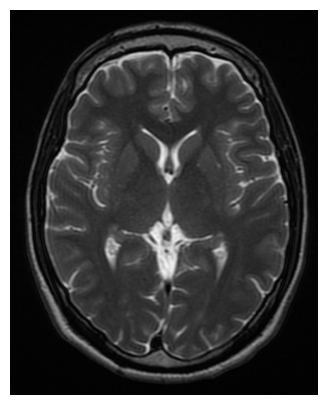

In [ ]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to('cpu')  # Move the model to the CPU

# Set the model to evaluation mode
model.eval()

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Take user input for the image file path
for i, sample_path in enumerate([sample_1, sample_2]):
    image_path = sample_path

    # Open and preprocess the user-input image
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)  # Add a batch dimension

    # Move the input data to the same device_d as the model
    img = img.to('cpu')

    # Make a prediction
    with torch.no_grad():
        output = model(img)

    # Print the raw scores and predicted probabilities
    print(f"Raw scores: {output}")
    probabilities = torch.sigmoid(output)
    print(f"Predicted probabilities: {probabilities}")

    # Assuming your model is for binary classification (sigmoid activation)
    predicted_class = torch.round(probabilities).item()
    print(f"Predicted class: {predicted_class}")

    # Print the result
    if predicted_class == 1:
        print("The model predicts: Yes")
    else:
        print("The model predicts: No")

    # Display the image
    sample_img = sample_path  # Change this line to the path of the image you want to plot
    fig, ax = plt.subplots(figsize=(5, 5))
    img = Image.open(sample_img)
    ax.imshow(img)
    ax.axis('off')
    plt.show()



In [ ]:
'/content/drive/My Drive/DL_Final_Project/brain_tumor_dataset/yes/Y259.JPG'

'/content/drive/My Drive/DL_Final_Project/brain_tumor_dataset/yes/Y259.JPG'

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!jupyter nbconvert --to html "/content/drive/My Drive/DL_Final_Project/Copy of brain-tumor-mri-detection-pytorch-cnn_resnet.ipynb"

[NbConvertApp] WARNING | pattern '/content/drive/My Drive/DL_Final_Project/Copy of brain-tumor-mri-detection-pytorch-cnn_resnet.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions ins